### Task 2

In [27]:
import logging
import pandas as pd
import os
import sys
import mlflow

sys.path.append(os.path.abspath('../scripts'))

from forecasting.arima_model import train_arima
from forecasting.sarima_model import train_sarima
from forecasting.lstm_model import preprocess_data, build_lstm, train_lstm
from forecasting.evaluation_metrics import evaluate_forecast
from utils.mlflow_utils import (
    start_mlflow_experiment, log_params, log_metrics, log_model, end_mlflow_experiment
)
import matplotlib.pyplot as plt

In [28]:
from utils.logging_config import setup_logger
setup_logger(log_file="task2_mlflow_forecasting.log", log_level=logging.INFO)

2024-11-17 15:24:08,152 - INFO - Logger initialized. Log file: logs\task2_mlflow_forecasting.log


In [29]:
logging.info("Task 2: Forecasting Pipeline with Multiple Datasets Started.")

2024-11-17 15:24:08,270 - INFO - Task 2: Forecasting Pipeline with Multiple Datasets Started.


In [30]:
datasets = {
    "TSLA": pd.read_csv("../data/processed/TSLA_processed.csv", parse_dates=["Date"], index_col="Date"),
    "SPY": pd.read_csv("../data/processed/SPY_processed.csv", parse_dates=["Date"], index_col="Date"),
    "BND": pd.read_csv("../data/processed/BND_processed.csv", parse_dates=["Date"], index_col="Date"),
}


### ARIMA

In [32]:
import warnings
warnings.filterwarnings("ignore")

results = {}

for name, data in datasets.items():
    logging.info(f"Processing dataset: {name}")

    train = data['Adj Close'][:'2019']
    test = data['Adj Close']['2020':]

    arima_orders = {
        "TSLA": (0, 1, 1),
        "SPY": (3, 1, 1),
        "BND": (0, 1, 0)
    }

    with mlflow.start_run(nested=True, run_name=f"ARIMA_{name}"):
        logging.info(f"Training ARIMA for {name} with order {arima_orders[name]}...")
        
        arima_model = train_arima(train, order=arima_orders[name])
        
        arima_forecast = arima_model.forecast(steps=len(test))
        
        arima_metrics = evaluate_forecast(test.values, arima_forecast)
        
        log_params({"dataset": name, "model": "ARIMA", "order": arima_orders[name]})
        log_metrics(arima_metrics)
        log_model(arima_model, f"arima_model_{name}")

        results[name] = {"test": test, "arima_forecast": arima_forecast}

        logging.info(f"Completed processing for {name}. Metrics: {arima_metrics}")

2024-11-17 15:27:16,094 - INFO - Processing dataset: TSLA
2024-11-17 15:27:16,344 - INFO - Training ARIMA for TSLA with order (0, 1, 1)...
2024-11-17 15:27:16,345 - INFO - Starting ARIMA training with order (0, 1, 1).
2024-11-17 15:27:16,400 - INFO - ARIMA training completed with order (0, 1, 1).
2024/11/17 15:27:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024-11-17 15:27:20,411 - INFO - Logged model: arima_model_TSLA to MLflow.
2024-11-17 15:27:20,419 - INFO - Completed processing for TSLA. Metrics: {'MAE': np.float64(178.48832758615592), 'RMSE': np.float64(202.56084136042602)}
2024-11-17 15:27:20,423 - INFO - Processing dataset: SPY
2024-11-17 15:27:20,573 - INFO - Training ARIMA for SPY with order (3, 1, 1)...
2024-11-17 15:27:20,573 - INFO - Starting ARIMA training with order (3, 1, 1).
2024-11-17 15:27:20,873 - INFO - ARIMA training completed with

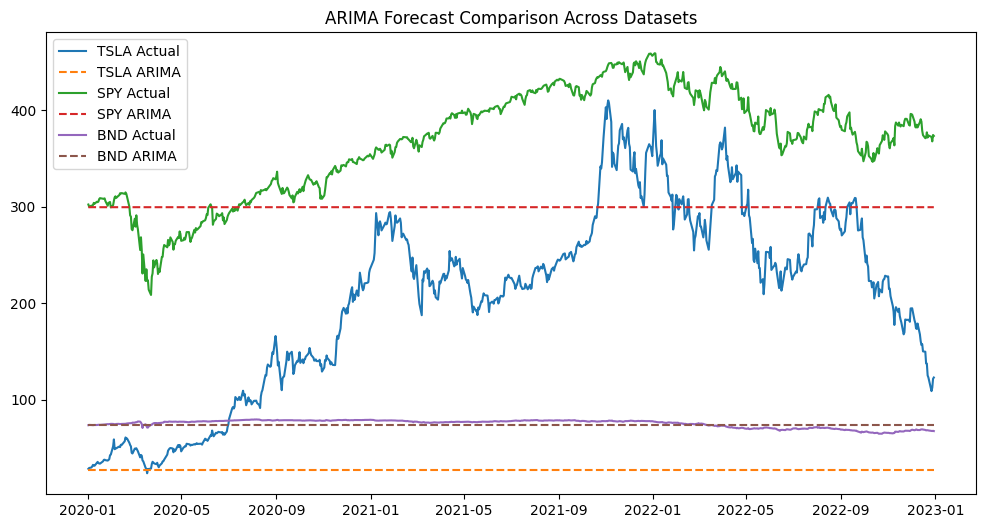

In [33]:
plt.figure(figsize=(12, 6))
for name, result in results.items():
    plt.plot(result["test"], label=f"{name} Actual", linestyle="solid")
    plt.plot(result["test"].index, result["arima_forecast"], label=f"{name} ARIMA", linestyle="--")
plt.legend()
plt.title("ARIMA Forecast Comparison Across Datasets")
plt.show()

In [34]:
plt.savefig("forecast_comparison.png")
mlflow.log_artifact("forecast_comparison.png")

<Figure size 640x480 with 0 Axes>

In [35]:
end_mlflow_experiment()
logging.info("Task 2: Forecasting Pipeline Completed.")

2024-11-17 15:36:35,079 - INFO - MLflow experiment ended.
2024-11-17 15:36:35,081 - INFO - Task 2: Forecasting Pipeline Completed.


### SARIMA

2024-11-17 16:13:50,132 - INFO - Processing dataset: TSLA
2024-11-17 16:13:50,139 - INFO - Training SARIMA for TSLA...
2024-11-17 16:13:50,139 - INFO - Training SARIMA model with order (1, 1, 1) and seasonal order (1, 1, 1, 12).
2024-11-17 16:13:56,199 - INFO - SARIMA model trained successfully. AIC: 1980.534372674969.
2024/11/17 16:14:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


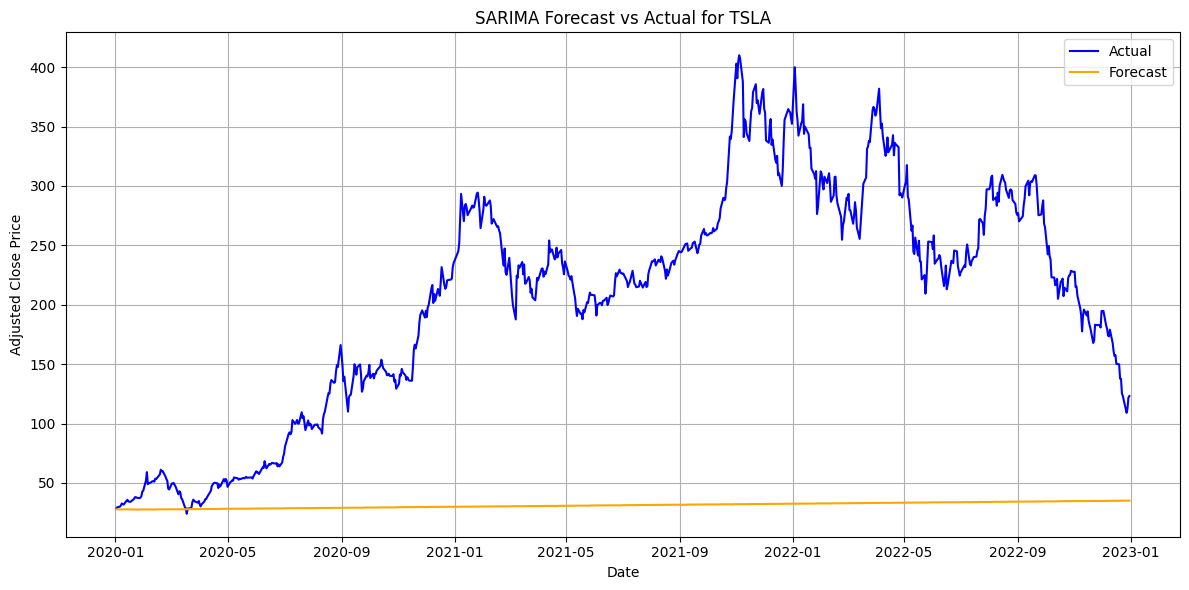

2024-11-17 16:14:41,261 - INFO - Processing dataset: SPY
2024-11-17 16:14:41,276 - INFO - Training SARIMA for SPY...
2024-11-17 16:14:41,276 - INFO - Training SARIMA model with order (2, 1, 2) and seasonal order (0, 1, 1, 12).
2024-11-17 16:14:55,690 - INFO - SARIMA model trained successfully. AIC: 5095.6537176047805.
2024/11/17 16:15:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


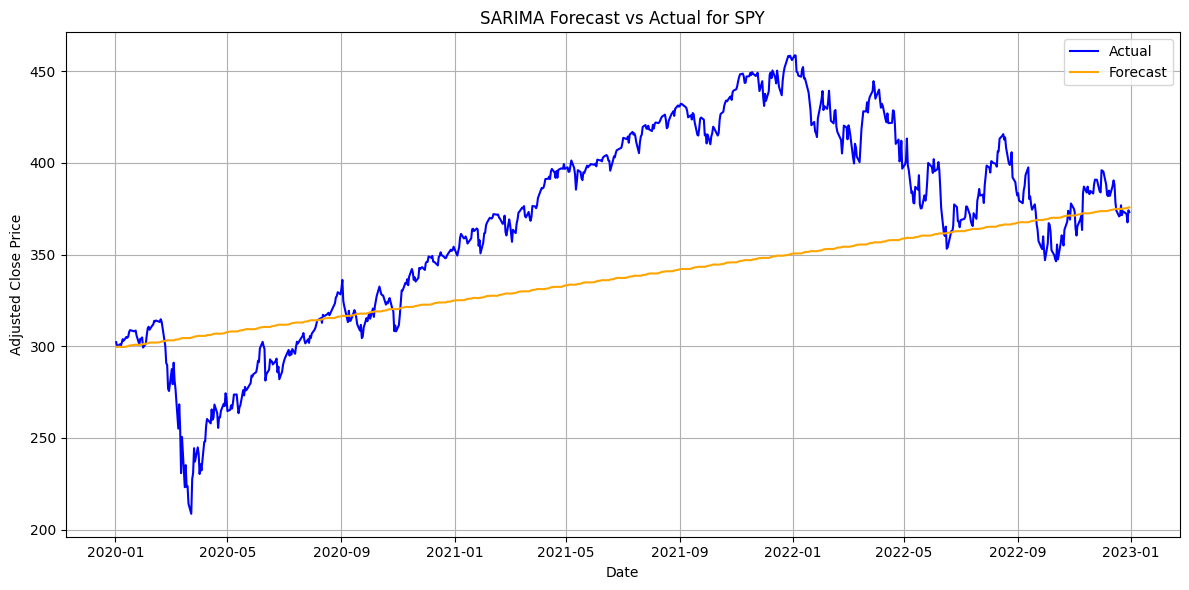

2024-11-17 16:15:07,344 - INFO - Processing dataset: BND
2024-11-17 16:15:07,344 - INFO - Training SARIMA for BND...
2024-11-17 16:15:07,354 - INFO - Training SARIMA model with order (0, 1, 1) and seasonal order (1, 0, 0, 12).
2024-11-17 16:15:08,095 - INFO - SARIMA model trained successfully. AIC: -1471.8426073419057.
2024/11/17 16:15:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


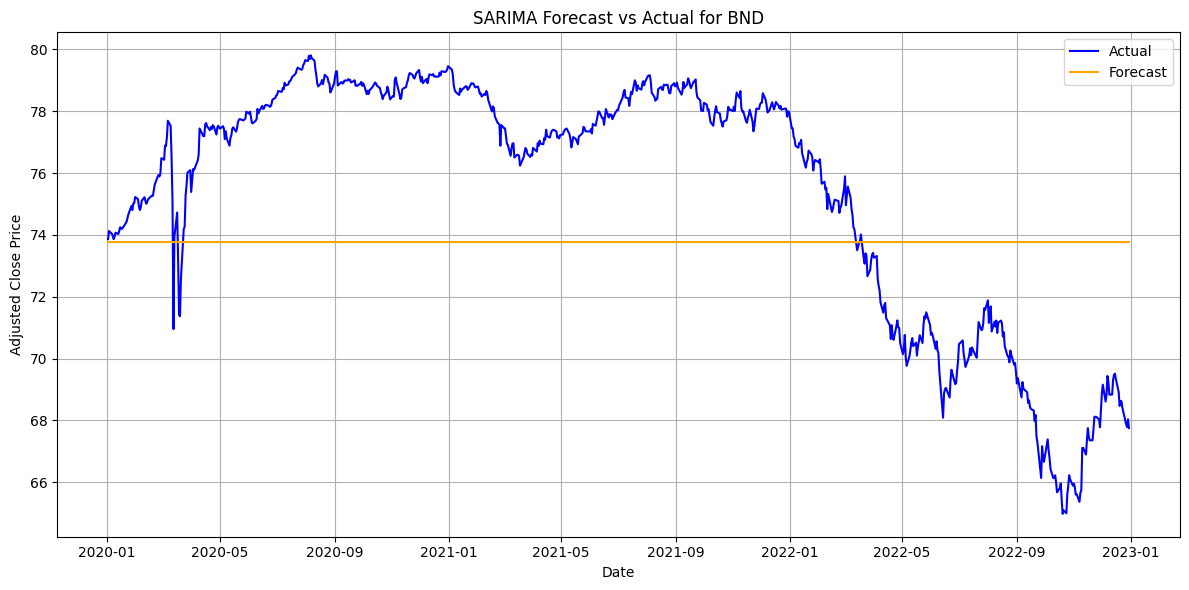

In [42]:
with mlflow.start_run(run_name="SARIMA_All_Datasets"):
    for name, data in datasets.items():
        with mlflow.start_run(run_name=f"SARIMA_{name}", nested=True):
            logging.info(f"Processing dataset: {name}")
            train = data['Adj Close'][:'2019']
            test = data['Adj Close']['2020':]

            logging.info(f"Training SARIMA for {name}...")
            orders = sarima_orders[name]
            sarima_model = train_sarima(
                train, order=orders["order"], seasonal_order=orders["seasonal_order"]
            )
            sarima_forecast = sarima_model.forecast(steps=len(test))
            sarima_metrics = evaluate_forecast(test.values, sarima_forecast)

            mlflow.log_params({
                "dataset": name,
                "model": "SARIMA",
                "order": orders["order"],
                "seasonal_order": orders["seasonal_order"]
            })
            mlflow.log_metrics(sarima_metrics)
            mlflow.sklearn.log_model(sarima_model, f"sarima_model_{name}")

            results[name] = {"test": test, "sarima_forecast": sarima_forecast}
           
            plt.figure(figsize=(12, 6))
            plt.plot(test.index, test.values, label="Actual", color="blue")
            plt.plot(test.index, sarima_forecast, label="Forecast", color="orange")
            plt.title(f"SARIMA Forecast vs Actual for {name}")
            plt.xlabel("Date")
            plt.ylabel("Adjusted Close Price")
            plt.legend()
            plt.grid()
            plt.tight_layout()

            
            plot_path = f"{name}_sarima_forecast.png"
            plt.savefig(plot_path)
            mlflow.log_artifact(plot_path)
            plt.show()

### LSTM

2024-11-17 17:13:16,285 - INFO - Processing dataset: TSLA
2024-11-17 17:13:16,319 - INFO - Training LSTM...
2024-11-17 17:13:16,320 - INFO - Data preprocessed for LSTM. Total sequences: 1198.
2024-11-17 17:13:16,320 - INFO - Data preprocessed for LSTM. Total sequences: 696.
2024-11-17 17:13:16,352 - INFO - LSTM model built and compiled.
2024-11-17 17:13:16,364 - INFO - Training LSTM model. Epochs: 50, Batch size: 32.


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0513
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0051
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0037
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0038
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0036
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0031
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0032
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0027
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0027
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0029
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0024
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0026
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0018
Epoc

2024-11-17 17:14:26,848 - INFO - LSTM model trained successfully.


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


2024/11/17 17:14:27 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/11/17 17:15:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


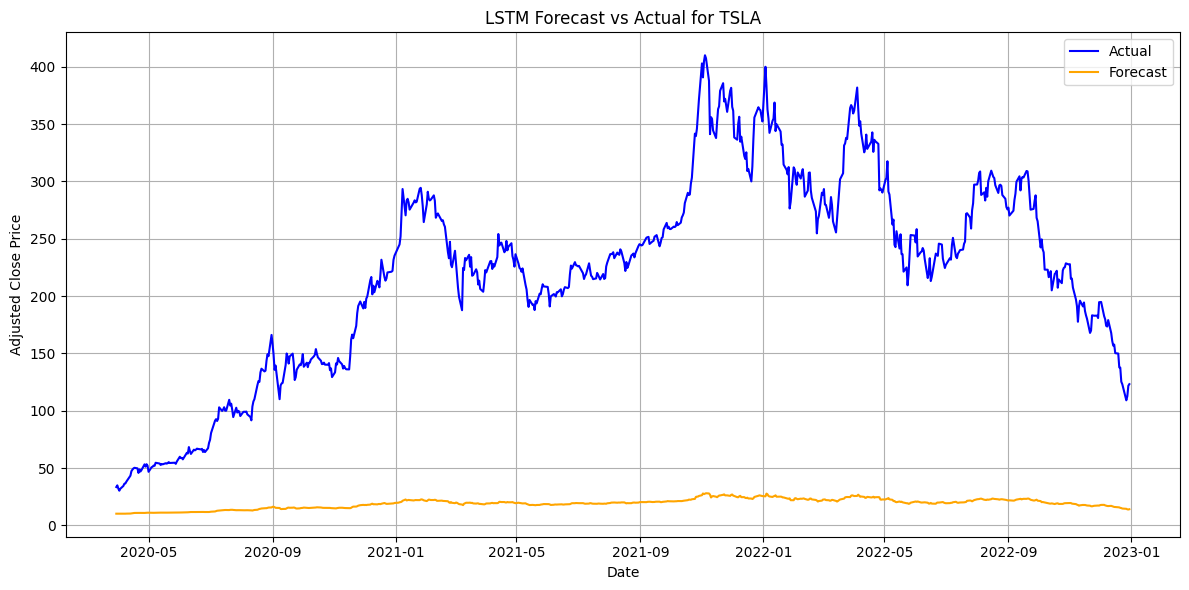

2024-11-17 17:15:36,919 - INFO - Processing dataset: SPY
2024-11-17 17:15:36,922 - INFO - Training LSTM...
2024-11-17 17:15:36,924 - INFO - Data preprocessed for LSTM. Total sequences: 1198.
2024-11-17 17:15:36,928 - INFO - Data preprocessed for LSTM. Total sequences: 696.
2024-11-17 17:15:36,974 - INFO - LSTM model built and compiled.
2024-11-17 17:15:36,974 - INFO - Training LSTM model. Epochs: 50, Batch size: 32.


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0645
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0014
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 8.7044e-04
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.9330e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.4953e-04
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 9.5533e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 7.9017e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7.5805e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 7.5309e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 7.0021e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 7.7305e-04
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 7.6432e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 6.6496e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 7.7128e-04
Epoch 15/50
38/38 ━━━━━

2024-11-17 17:16:37,661 - INFO - LSTM model trained successfully.


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


2024/11/17 17:16:38 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/11/17 17:16:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


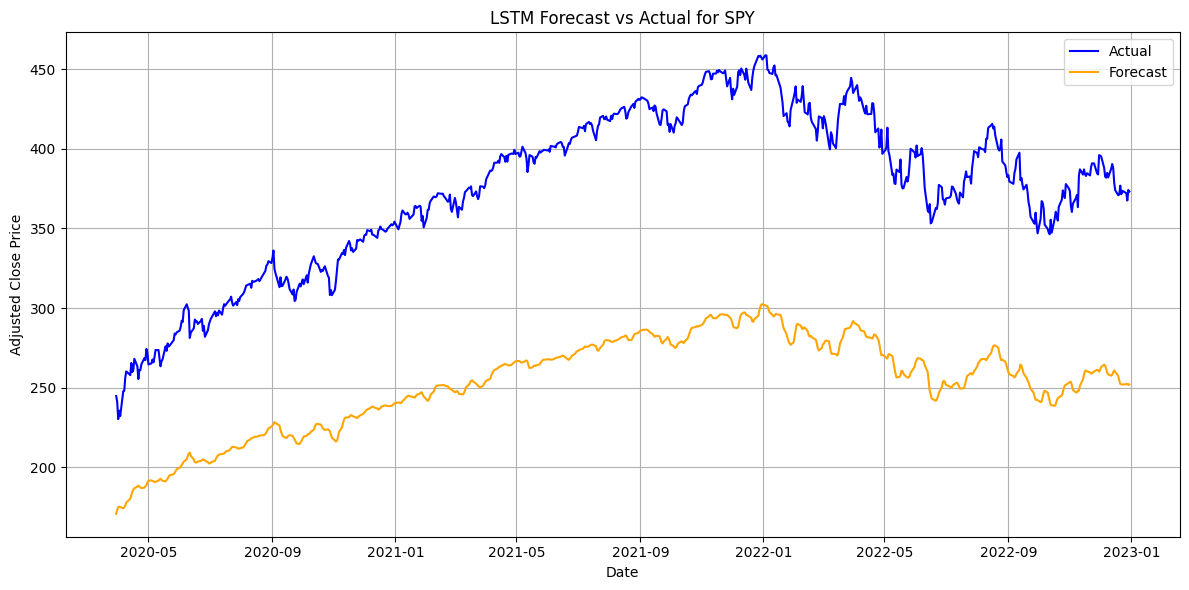

2024-11-17 17:16:47,075 - INFO - Processing dataset: BND
2024-11-17 17:16:47,077 - INFO - Training LSTM...
2024-11-17 17:16:47,080 - INFO - Data preprocessed for LSTM. Total sequences: 1198.
2024-11-17 17:16:47,082 - INFO - Data preprocessed for LSTM. Total sequences: 696.
2024-11-17 17:16:47,119 - INFO - LSTM model built and compiled.
2024-11-17 17:16:47,119 - INFO - Training LSTM model. Epochs: 50, Batch size: 32.


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0508
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0012
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 6.7464e-04
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 6.8562e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 6.6495e-04
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 6.9171e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 6.3200e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 6.4498e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 6.3798e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 6.2227e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 5.8897e-04
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6.1700e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 5.9354e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 5.5222e-04
Epoch 15/50
38/38 ━━━━━

2024-11-17 17:17:50,904 - INFO - LSTM model trained successfully.


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


2024/11/17 17:17:51 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/11/17 17:18:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


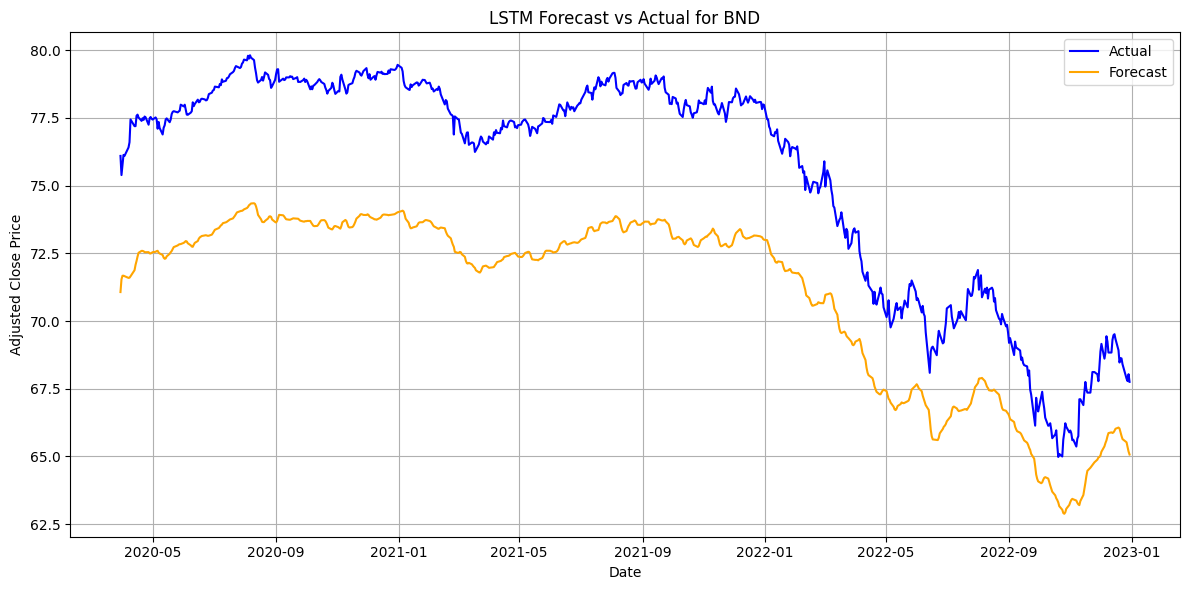

In [45]:
window_size = 60
epochs = 50
batch_size = 32

if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run(run_name="LSTM_All_Datasets"):
    for name, data in datasets.items():
        with mlflow.start_run(run_name=f"LSTM_{name}", nested=True):
            logging.info(f"Processing dataset: {name}")

            train = data['Adj Close'][:'2019']
            test = data['Adj Close']['2020':]

            logging.info("Training LSTM...")

            x_train, y_train, scaler = preprocess_data(train, window_size)
            x_test, _, _ = preprocess_data(test, window_size)

            lstm_model = build_lstm(input_shape=(x_train.shape[1], 1))
            trained_lstm_model = train_lstm(lstm_model, x_train, y_train, epochs=epochs, batch_size=batch_size)
            lstm_forecast = trained_lstm_model.predict(x_test)
            lstm_forecast_rescaled = scaler.inverse_transform(lstm_forecast)

            lstm_metrics = evaluate_forecast(
                test[window_size:].values, lstm_forecast_rescaled.flatten()
            )

            mlflow.log_params({
                "dataset": name,
                "model": "LSTM",
                "window_size": window_size,
                "epochs": epochs,
                "batch_size": batch_size
            })
            mlflow.log_metrics(lstm_metrics)
            mlflow.tensorflow.log_model(trained_lstm_model, f"lstm_model_{name}")

            plt.figure(figsize=(12, 6))
            plt.plot(test.index[window_size:], test[window_size:].values, label="Actual", color="blue")
            plt.plot(test.index[window_size:], lstm_forecast_rescaled.flatten(), label="Forecast", color="orange")
            plt.title(f"LSTM Forecast vs Actual for {name}")
            plt.xlabel("Date")
            plt.ylabel("Adjusted Close Price")
            plt.legend()
            plt.grid()
            plt.tight_layout()

            plot_path = f"{name}_lstm_forecast.png"
            plt.savefig(plot_path)
            mlflow.log_artifact(plot_path)
            plt.show()

mlflow.end_run()